<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Segmentation_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

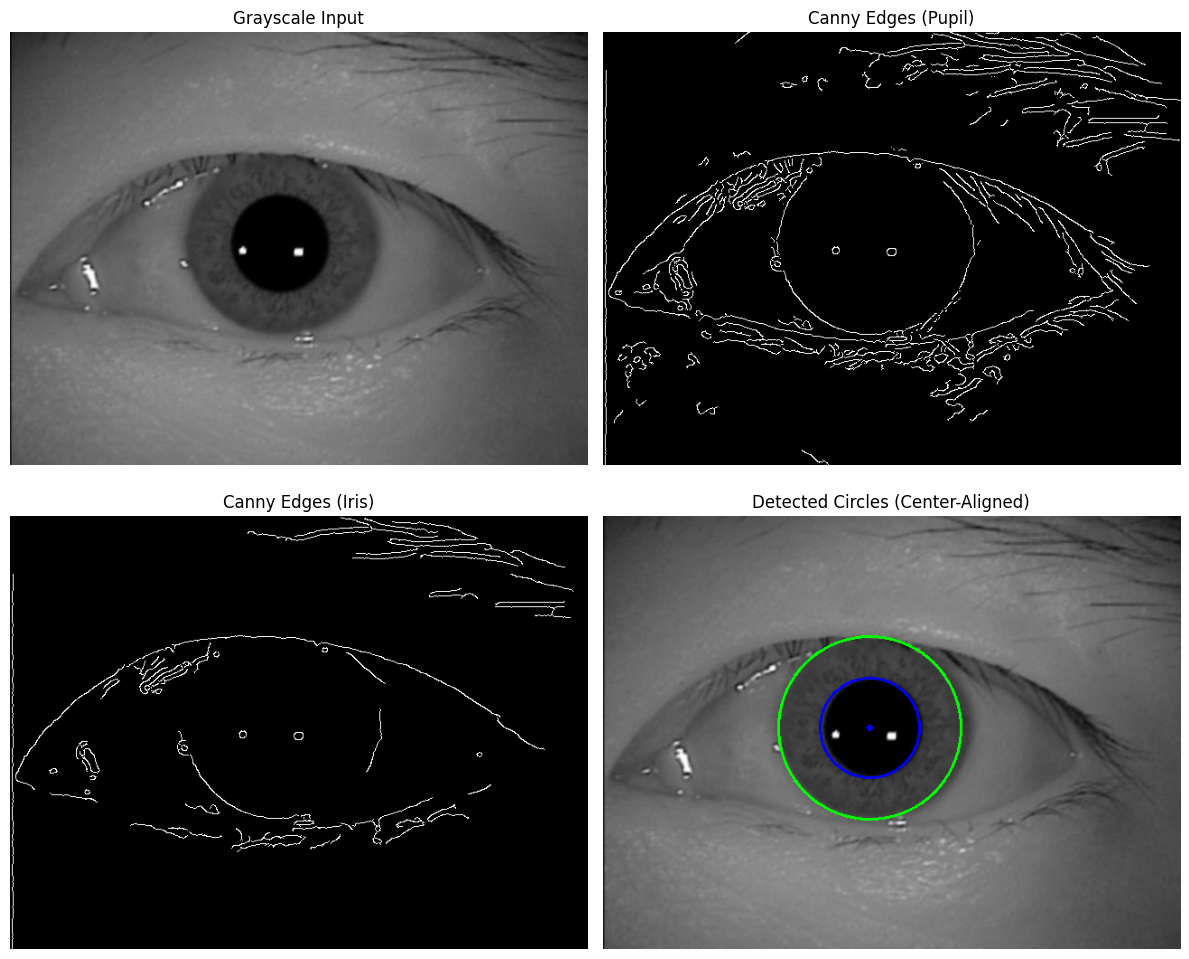

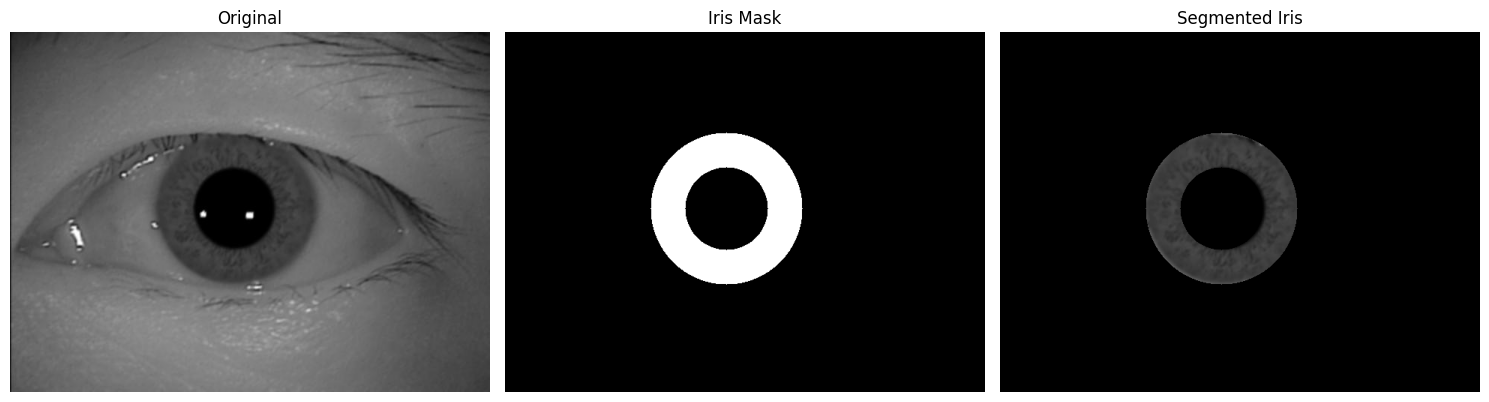

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
image_path = "/content/S6000S00.jpg"
original = cv2.imread(image_path)
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# === Step 1: Preprocessing ===
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (7, 7), 2)

# === Step 2: Edge Detection for Pupil ===
edges_pupil = cv2.Canny(blurred, threshold1=30, threshold2=80)

# === Step 3: Hough Circle Transform for Pupil (initial)
pupil_circles = cv2.HoughCircles(
    edges_pupil,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=gray.shape[0] // 8,
    param1=100,
    param2=15,
    minRadius=20,
    maxRadius=60
)

# === Step 4: Edge Detection for Iris ===
edges_iris = cv2.Canny(blurred, threshold1=50, threshold2=150)

# === Step 5: Hough Circle Transform for Iris
iris_circles = cv2.HoughCircles(
    edges_iris,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=gray.shape[0] // 4,
    param1=100,
    param2=30,
    minRadius=60,
    maxRadius=120
)

# === Step 6: Draw Results ===
output = original.copy()

# Draw iris first
iris_center = None
if iris_circles is not None:
    iris_circles = np.uint16(np.around(iris_circles))
    x, y, r = iris_circles[0][0]
    iris_center = (x, y)
    cv2.circle(output, iris_center, r, (0, 255, 0), 2)
    cv2.circle(output, iris_center, 2, (0, 255, 0), 3)

# Draw adjusted pupil
if pupil_circles is not None and iris_center is not None:
    pupil_circles = np.uint16(np.around(pupil_circles))
    _, _, r = pupil_circles[0][0]  # use detected radius
    cv2.circle(output, iris_center, r, (255, 0, 0), 2)  # center aligned to iris
    cv2.circle(output, iris_center, 2, (255, 0, 0), 3)

# === Step 7: Visualization ===
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0][0].imshow(gray, cmap='gray')
axs[0][0].set_title("Grayscale Input")
axs[0][1].imshow(edges_pupil, cmap='gray')
axs[0][1].set_title("Canny Edges (Pupil)")
axs[1][0].imshow(edges_iris, cmap='gray')
axs[1][0].set_title("Canny Edges (Iris)")
axs[1][1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1][1].set_title("Detected Circles (Center-Aligned)")
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

# Histogram equalization + blur (match preprocessing)
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (7, 7), 2)

# Edge detection
edges_pupil = cv2.Canny(blurred, 30, 80)
edges_iris = cv2.Canny(blurred, 50, 150)

# Detect pupil circle
pupil_circles = cv2.HoughCircles(
    edges_pupil, cv2.HOUGH_GRADIENT, dp=1.2,
    minDist=gray.shape[0] // 8, param1=100, param2=15,
    minRadius=20, maxRadius=60
)

# Detect iris circle
iris_circles = cv2.HoughCircles(
    edges_iris, cv2.HOUGH_GRADIENT, dp=1.2,
    minDist=gray.shape[0] // 4, param1=100, param2=30,
    minRadius=60, maxRadius=120
)

# Create mask
mask = np.zeros(gray.shape, dtype=np.uint8)

if iris_circles is not None and pupil_circles is not None:
    iris_circles = np.uint16(np.around(iris_circles))
    pupil_circles = np.uint16(np.around(pupil_circles))

    # Use iris center for both (aligned centers)
    cx, cy = iris_circles[0][0][:2]
    outer_r = iris_circles[0][0][2]
    inner_r = pupil_circles[0][0][2]

    # Draw white ring for iris (donut shape)
    cv2.circle(mask, (cx, cy), outer_r, 255, -1)    # outer circle white
    cv2.circle(mask, (cx, cy), inner_r, 0, -1)      # inner circle black

    # Apply mask to original
    iris_segmented = cv2.bitwise_and(original, original, mask=mask)

    # Display
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Iris Mask")
    axs[2].imshow(cv2.cvtColor(iris_segmented, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Segmented Iris")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

else:
    print("Circles not detected.")